In [1]:
%matplotlib notebook

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sympy as sp
import networkx as nx
from random import shuffle

from pydivest.macro_model.integrate_equations_rep import Integrate_Equations as rep
from pydivest.macro_model.integrate_equations_aggregate import Integrate_Equations as agg
from pydivest.macro_model.integrate_equations_mean import Integrate_Equations as mean
from pydivest.micro_model.divestmentcore import DivestmentCore as micro

Could not find GLIMDA


In [2]:
## Set parameters and generate initial conditions.

# possible cue orders
possible_cue_orders = [[0], [1]]
# and their frequencies:
n_cos = [10, 90]

# Parameters:
input_parameters = {'i_tau': 1., 'eps': .01, 'b_d': 1.4,
                    'b_c': 1., 'i_phi': .7, 'e': 10,
                    'G_0': 1000, 'b_r0': 0.1 ** 2 * 100,
                    'possible_cue_orders': possible_cue_orders,
                    'C': 100, 'xi': 1. / 8., 'd_c': 0.06, 's': 0.23,
                    'campaign': False, 'learning': True,
                    'crs': True, 'interaction': 2, 'deltap': 0.}

# generate a set of investment decisions/opinions of households
opinions = []
for i, n in enumerate(n_cos):
    opinions.append(np.full(n, i, dtype='I'))
opinions = [item for sublist in opinions for item in sublist]
shuffle(opinions)

# generate an acquaintance network of households:
N = sum(n_cos)
p = .2
while True:
    net = nx.erdos_renyi_graph(N, p)
    if len(list(net)) > 1:
        break
adjacency_matrix = nx.adj_matrix(net).toarray()

# set households capital endowments in clean and dirty sectors
clean_investment = .5 * np.ones(N)
dirty_investment = np.ones(N)

init_conditions = (adjacency_matrix, opinions,
                   clean_investment, dirty_investment)

# initialize the representative household model
models = {}
models['rep'] = rep(*init_conditions, **input_parameters)

# and use it to to set the fraction of clean and dirty investing households (n)
# and the knowledge stock to 'optimal' values i.e. such that capital return rates
# are equal in both sectors
C, n = models['rep'].find_initial_conditions()

# use these values to update initial conditions:
input_parameters['C'] = C

n_cos = [int(round((1.-n) * 100.)), int(round(n * 100.))]
opinions = []
for i, n in enumerate(n_cos):
    opinions.append(np.full((n), i, dtype='I'))
opinions = [item for sublist in opinions for item in sublist]
shuffle(opinions)

N = sum(n_cos)
p = .2

while True:
    net = nx.erdos_renyi_graph(N, p)
    if len(list(net)) > 1:
        break
adjacency_matrix = nx.adj_matrix(net).toarray()

# use these updated initial conditions to initialize the other models.
init_conditions = (adjacency_matrix, opinions,
                   clean_investment, dirty_investment)

models['agg'] = agg(*init_conditions, **input_parameters)
models['mean'] = mean(*init_conditions, **input_parameters)
models['micro'] = micro(*init_conditions, **input_parameters)

got superfluous keyword arguments
dict_keys(['possible_cue_orders', 'campaign', 'learning', 'deltap'])
pi = 0.5, xi = 0.125, kappa_c = 0.375, kappa_d = 0.5
sanitizing initial conditions to
{K_c: 50.0, K_d: 100.0, G: 1000.0, C: 1003.8973589884101, n: 0.11829877050308692}
got superfluous keyword arguments
dict_keys(['possible_cue_orders', 'campaign', 'learning', 'deltap'])
pi = 0.5, xi = 0.125, kappa_c = 0.375, kappa_d = 0.5
define economic equations,
loading rhs successful
got superfluous keyword arguments
dict_keys(['possible_cue_orders', 'campaign', 'learning', 'deltap'])
pi = 0.5, xi = 0.125, kappa_c = 0.375, kappa_d = 0.5
loading rhs successful


In [3]:
# run models
t_max = 100
for model in models.values():
    model.run(t_max=t_max, t_steps=t_max)

[IDA Warning] b'At the end of the first step, there are still some root functions identically 0. This warning will not be issued again.'
[IDA Warning] b'At the end of the first step, there are still some root functions identically 0. This warning will not be issued again.'
Final Run Statistics: --- ===================================] 100.0% ...representative agent running

 Number of steps                                 : 348
 Number of function evaluations                  : 474
 Number of Jacobian evaluations                  : 49
 Number of function eval. due to Jacobian eval.  : 245
 Number of error test failures                   : 8
 Number of nonlinear iterations                  : 474
 Number of nonlinear convergence failures        : 0
 Number of state function evaluations            : 361
 Number of state events                          : 2

Solver options:

 Solver                       : IDA (BDF)
 Maximal order                : 5
 Suppressed algebr. variables : False
 To

In [4]:
# get unified trajectories from models
trajectories = {name: model.get_unified_trajectory() for name, model in models.items()}

<IPython.core.display.Javascript object>


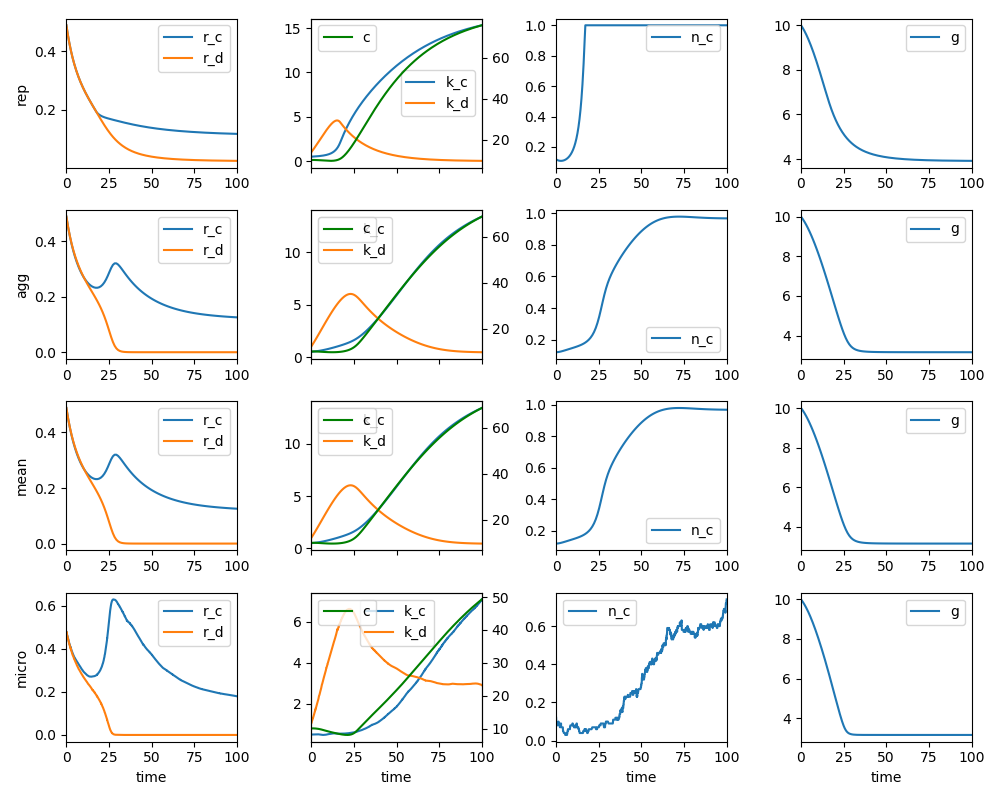

In [5]:
# plot some of the variables from the unified trajectories

slots = len(list(models.keys()))
    
fig = plt.figure(figsize=(10,2 * slots))

for i, name in enumerate(models.keys()):
    trj = trajectories[name][:t_max]
    ax = fig.add_subplot(slots, 4, 1 + 4*i)
    ax.set_ylabel(name)
    trj[['r_c', 'r_d']].plot(ax=ax)
    leg = ax.get_legend()
    #leg.set_bbox_to_anchor(bbox=(1,1))

    ax2 = fig.add_subplot(slots, 4, 2 + 4*i)
    trj[['k_c', 'k_d']].plot(ax=ax2)
    ax2b = ax2.twinx()
    trj[['c']].plot(ax=ax2b, color='g')

    ax3 = fig.add_subplot(slots, 4, 3 + 4*i)
    trj[['n_c']].plot(ax=ax3)
    
    ax4 = fig.add_subplot(slots, 4, 4 + 4*i)
    trj[['g']].plot(ax=ax4)

    fig.tight_layout()

<IPython.core.display.Javascript object>


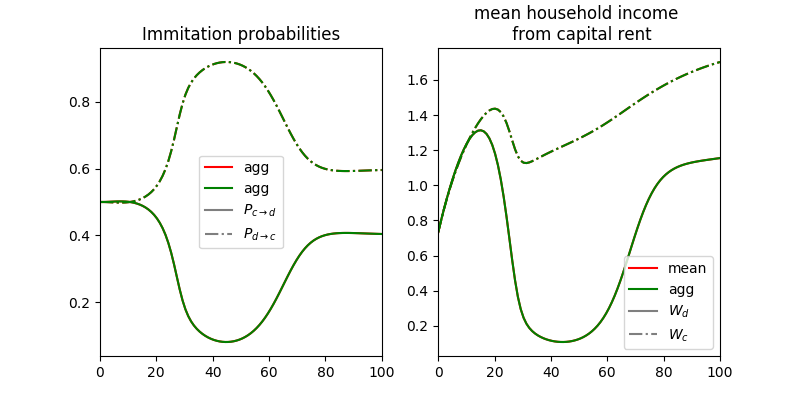

In [22]:
fig = plt.figure(figsize=(8, 4))

colors = 'rgb'
ax = fig.add_subplot(121)
ax.set_title('Immitation probabilities')
trj = trajectories['mean']
trj['Pcd'].plot(ax=ax, color='r', label=name)
trj['Pdc'].plot(ax=ax, color='r', style='-.', label='__no_label__')
trj = trajectories['agg']
trj['Pcd'].plot(ax=ax, color='g', label=name)
trj['Pdc'].plot(ax=ax, color='g', style='-.', label='__no_label__')
ax.plot([0], [0.5], 'k-', alpha=.5, label=r'$P_{c \rightarrow d}$')
ax.plot([0], [0.5], 'k-.', alpha=.5, label=r'$P_{d \rightarrow c}$')

plt.legend()

ax2 = fig.add_subplot(122)
ax2.set_title('mean household income \n from capital rent')
for i, name in enumerate(['mean', 'agg']):
    trj = trajectories[name]
    trj['W_d'].plot(ax=ax2, color=colors[i], label=name)
    trj['W_c'].plot(ax=ax2, color=colors[i], style='-.', label='__no_label__')
ax2.plot([0], [0.5], 'k-', alpha=.5, label=r'$W_{d}$')
ax2.plot([0], [0.5], 'k-.', alpha=.5, label=r'$W_{c}$')
plt.legend()

<IPython.core.display.Javascript object>


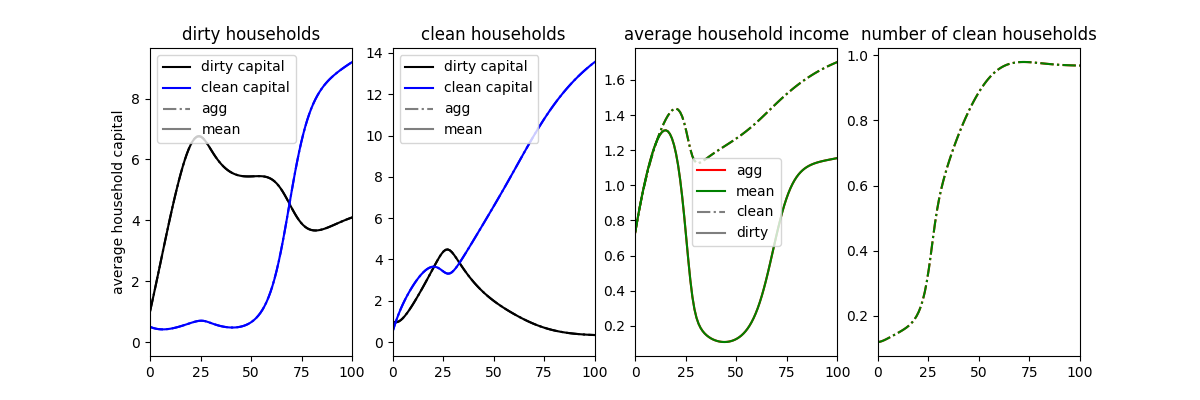

/home/jakob/anaconda3/envs/forge/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


In [9]:
tra = models['agg'].get_aggregate_trajectory()
trm = models['mean'].get_mean_trajectory()

fig=plt.figure(figsize=(12,4))
ax=fig.add_subplot(141)
ax.set_title('dirty households')
ax.set_ylabel('average household capital')
(2./100*tra['K_d^d']/(1-tra['x'])).plot(ax=ax, color='k', style='-.', label='__no_label__')
trm['mu_d^d'].plot(ax=ax, color='k', label='dirty capital')
(2./100*tra['K_c^d']/(1-tra['x'])).plot(ax=ax, color='b', style='-.', label='__no_label__')
trm['mu_c^d'].plot(ax=ax, color='b', label='clean capital')
ax.plot([0], [0], 'k-.', label='agg', alpha=.5)
ax.plot([0], [0], 'k-', label='mean', alpha=.5)
plt.legend()

ax2=fig.add_subplot(142)
ax2.set_title('clean households')
(2./100*tra['K_d^c']/(1+tra['x'])).plot(ax=ax2, color='k', style='-.', label='__no_label__')
trm['mu_d^c'].plot(ax=ax2, color='k', label='dirty capital')
(2./100*tra['K_c^c']/(1+tra['x'])).plot(ax=ax2, color='b', style='-.', label='__no_label__')
trm['mu_c^c'].plot(ax=ax2, color='b', label='clean capital')
ax2.plot([0], [0], 'k-.', label='agg', alpha=.5)
ax2.plot([0], [0], 'k-', label='mean', alpha=.5)
plt.legend()

ax3 = fig.add_subplot(143)
ax3.set_title('average household income')
for i, name in enumerate(['agg', 'mean']):
    trj = trajectories[name]
    trj['W_d'].plot(ax=ax3, color=colors[i], label=name)
    trj['W_c'].plot(ax=ax3, color=colors[i], style='-.', label='__no_label__')
ax3.plot([0], [0.732], 'k-.', label='clean', alpha=.5)
ax3.plot([0], [0.732], 'k-', label='dirty', alpha=.5)
plt.legend()
    
ax4 = fig.add_subplot(144)
ax4.set_title('number of clean households')
for i, name in enumerate(['agg', 'mean']):
    trj = trajectories[name]
    trj['n_c'].plot(ax=ax4, color=colors[i], style='-.', label='__no_label__')
    plt.legend()